# 1. Linear Tree Parser

In conclusion, the model from LightGBM can be saved into a JSON format. We use level order traversal and save each node into the nested dictionary. 

In the nested dictionary, the split node has keys:
* threshold
* split_feature
* parent(the first node doesn't have)

the leaf node has keys:
* parent
* leaf_const
* leaf_coeff

Below are code and output

## code

In [ ]:
# change the model to json format
whole_model = model_linear.dump_model() # model_linear is the trained model
# query the last tree
node  = whole_model['tree_info'][-1]["tree_structure"]

In [ ]:
queue = [node]
dict = {}

# save the very first node into the dict
dict["split"+str(queue[0]["split_index"])] = {'split_index': queue[0]["split_index"],
                                 'threshold': queue[0]["threshold"], }

# level order traversal
while queue:

    # left child
    if "left_child" in queue[0].keys():
        queue.append(queue[0]["left_child"])
        # child is a split
        if "split_index" in queue[0]["left_child"].keys():
            dict["split"+str(queue[0]["left_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                           'threshold': queue[0]["left_child"]["threshold"], 
                                                           'split_feature': queue[0]["left_child"]["split_feature"]}
        # child is a leaf
        else:
            dict["leaf"+str(queue[0]["left_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                          'leaf_const': queue[0]["left_child"]["leaf_const"], 
                                                          'leaf_coeff': queue[0]["left_child"]["leaf_coeff"]}
            
    # right child
    if "right_child" in queue[0].keys():
        queue.append(queue[0]["right_child"])      
        # child is a split
        if "split_index" in queue[0]["right_child"].keys():
            dict["split"+str(queue[0]["right_child"]["split_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                           'threshold': queue[0]["right_child"]["threshold"], 
                                                           'split_feature': queue[0]["right_child"]["split_feature"]}
        # child is a leaf
        else:
            dict["leaf"+str(queue[0]["right_child"]["leaf_index"])] = {'parent': "split"+str(queue[0]["split_index"]),
                                                          'leaf_const': queue[0]["right_child"]["leaf_const"], 
                                                          'leaf_coeff': queue[0]["right_child"]["leaf_coeff"]}
    # delet the first elment in the queue
    queue.pop(0)

## Output

In [ ]:
{'split0': {'split_index': 0, 'threshold': 3.2650000000000006},
 'split2': {'parent': 'split0',
  'threshold': -8.364999999999998,
  'split_feature': 0},
 'split1': {'parent': 'split0',
  'threshold': 22.050000000000004,
  'split_feature': 0},
 'leaf0': {'parent': 'split2',
  'leaf_const': -0.2902764210366918,
  'leaf_coeff': [-0.02229777591165156]},
 'leaf3': {'parent': 'split2',
  'leaf_const': -0.2451576806147419,
  'leaf_coeff': [-0.012823549889195006]},
 'leaf1': {'parent': 'split1',
  'leaf_const': 0.7182081149997852,
  'leaf_coeff': [-0.039159652311451076]},
 'split3': {'parent': 'split1',
  'threshold': 33.65000000000001,
  'split_feature': 0},
 'leaf2': {'parent': 'split3',
  'leaf_const': -0.8220879353385486,
  'leaf_coeff': [0.02656011635781838]},
 'leaf4': {'parent': 'split3',
  'leaf_const': 0.06178426010660609,
  'leaf_coeff': [-0.0011589960475504382]}}

# 2. Test

## Our future work

- Generate a tree model
- Result from tree parser
  - dict has every item
- Result from reformulation
  - Same as hard code GT
  - Same as prediction from package
  - Scalling

## Work in OMLT and scikit-learn

## io

### test_input_bounds

I think it is a built-in function, and every io will need this. So we don't need to imitate it.

### test_keras_reader

They load existing nn model, check the result of _load_keras_sequential_, e.g. # of layers, activation function and the shape of weights.

### test_onnx_parser

They load existing nn model, check the result of _load_onnx_neural_network_, e.g. # of layer, activation function and the shape of weights.

## gbt

### test_gbt_formulation

They load existing gbt model from onnx, reformulate the model, and then check the result, e.g. # of variable, # of constraint, # of node(?), # of feature, # of singe leaf, # of left split, # of right splt, # of categorical, # of variable lower bound, # of variable upper bound.

## nn

### train_keras_models

They use keras to generate nns for other test problems as benchmark.

### test_layer

They test the _input_indexes_ and the result after different layers.

### test_onnx

They check _load_onnx_neural_network_ and use different activation function, linear, relu, sigmoid. They also check the _scaled_input_bound_ when nn model is load through _load_onnx_neural_network_with_bounds_.

### test_relu

They hard code input and output, compare the output from reluformulation(different representation for relu) with the hard code.

```
from omlt.neuralnet import (
    FullSpaceNNFormulation,
    ReluBigMFormulation,
    ReluComplementarityFormulation,
    ReluPartitionFormulation,
)
```

### test_network_definition

They check the scaling in building nn.

### test_nn_formulation

They hard code input and output, compare the output from reformulation(different representation for nn) with the hard code.

```
from omlt.neuralnet import (
    FullSpaceNNFormulation,
    FullSpaceSmoothNNFormulation,
    NetworkDefinition,
    ReducedSpaceNNFormulation,
    ReducedSpaceSmoothNNFormulation,
)
```

### test_keras

They compare the output from reformulation with the keras predicted one.

## [scikit-learn](https://github.com/scikit-learn/scikit-learn/tree/main/sklearn/tree/tests)

- toy sample: X, y, T
- iris dataset
- diabetes dataset


# 3. Explanation for the LightGBM

## 3.1 how the tree is generated (```num_iterations```)

They use method from Xgboost to decide where to split. 

- $1^{st}$ iteration, the prediction($\hat{y}_i^0$) is essentially the average of every sample allocated to each leaf. So we can see the step-like plot. 

- following iteration, ${res}_i$ = $\hat{y}_i^0 - y_i$. Then they fit a tree using the input and residuals, say ```Tree(X, res)```. Then the linear tree is updated using the residual tree and there is new residuals created from the predication and ground truth. Then the new residual tree is created and the linear tree is updated once again. 

This is why there is iteration in the algorithm(same as [GBDT](https://www.analyticsvidhya.com/blog/2021/04/how-the-gradient-boosting-algorithm-works/), Xgboost). It is essentially how many times to fit the residual and update the linear tree. In each iteration, the new tree is trained from the begining, so ```num_iterations``` are also ```num_trees```.

## 3.2 how the intercept and the slope is created

In one word, first split, then fit. In the fitting part, they use linear regression to fit the input and output allocated to each leaf and get the coefficients. We also do some simulations on the fitting process and it is true. 

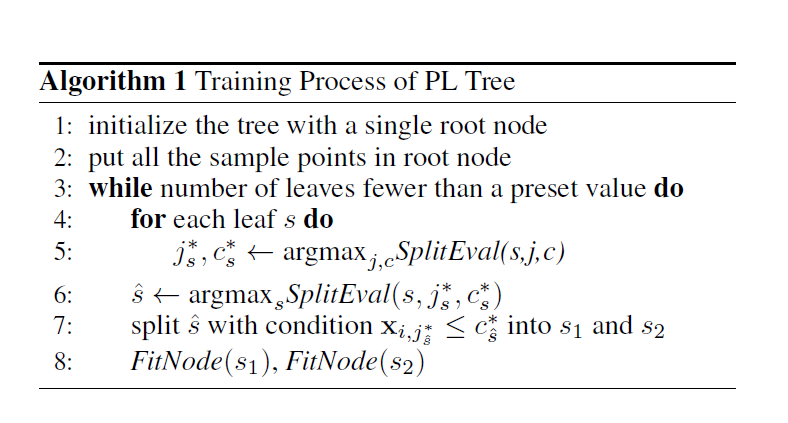

## 3.3 what is the ```learning_rate```(```shrinkage_rate```, η)

$\hat{y}^t_{i} = \hat{y}^t_{i-1} + η f_t(x_i)$ ($t$ is the number of iteration)

From the equation, the prediction of the $t^{th}$ model is based on the result of the ${t-1}^{th}$ plus the prediction of the $t^{th}$ model. A technique to slow down the learning in the gradient boosting model is to apply a weighting factor for the corrections by new trees(say, the $t^{th}$ model) when added to the model. The purpose is to prevent overfitting. This in turn results in more trees that must be added to the model, because more trees and iterations can get a better result with fewer trees anditerations. 